<a href="https://colab.research.google.com/github/rahmansadiqgit/Thesis_Work/blob/master/Neural_Network_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PHISHING URL DETECTION - OPTIMIZED CNN MODEL


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [3]:
class URLPreprocessor:
    """Handles URL encoding and vocabulary creation"""

    def __init__(self, max_len=200):
        self.max_len = max_len
        self.char_to_idx = None
        self.vocab_size = None


    def fit(self, urls):
        """Build character vocabulary from URLs"""
        # Collect unique characters
        chars = set()
        for url in urls:
            chars.update(str(url).lower())

        # Add special URL characters
        special_chars = ['/', '.', '-', '_', '=', '?', '&', '%', ':', '@', '+', '~', '#']
        chars.update(special_chars)

        # Create mapping: 0=padding, 1=unknown
        self.char_to_idx = {char: idx+2 for idx, char in enumerate(sorted(chars))}
        self.char_to_idx['<PAD>'] = 0
        self.char_to_idx['<UNK>'] = 1
        self.vocab_size = len(self.char_to_idx)

        print(f"Vocabulary size: {self.vocab_size}")
        return self

    def encode_url(self, url):
        """Encode a single URL to integer sequence"""
        url = str(url).lower()
        encoded = [self.char_to_idx.get(c, 1) for c in url][:self.max_len]

        # Pad if necessary
        if len(encoded) < self.max_len:
            encoded += [0] * (self.max_len - len(encoded))

        return np.array(encoded)

    def transform(self, urls):
        """Encode multiple URLs"""
        return np.array([self.encode_url(url) for url in urls])

    def fit_transform(self, urls):
        """Fit and transform in one step"""
        self.fit(urls)
        return self.transform(urls)


In [4]:
def load_and_prepare_data(df, test_size=0.2, random_state=42):
    """Load data and split into train/validation sets"""

    # Initialize preprocessor
    preprocessor = URLPreprocessor(max_len=200)

    # Encode URLs
    X = preprocessor.fit_transform(df['URL'])
    y = df['label'].values

    print(f"Dataset shape: X={X.shape}, y={y.shape}")

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"\nTraining set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")

    return X_train, X_val, y_train, y_val, preprocessor

In [5]:
def create_phishing_detector(vocab_size, max_len=200):
    """
    Simplified CNN architecture for URL classification
    - Smaller, faster, more efficient
    - Better regularization to prevent overfitting
    """

    model = Sequential([
        # Character embedding
        Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),

        # First convolutional block
        Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),

        # Second convolutional block
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),

        # Global pooling
        GlobalMaxPooling1D(),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.4),

        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile with optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [6]:
# ============================================================================
# 3. TRAINING
# ============================================================================

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
    """Train the model with callbacks"""

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    return history

In [31]:
# ============================================================================
# 4. EVALUATION
# ============================================================================

def evaluate_model(model, X_test, y_test, plot=True):
    """Comprehensive model evaluation"""

    # Predictions
    y_pred_probs = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("="*60)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

    # Plot confusion matrix
    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[ 'Phishing' ,'Legitimate' ],
                    yticklabels=[ 'Phishing' , 'Legitimate'],
                    cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('Actual Label', fontsize=12)
        plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%} | F1-Score: {f1:.4f}',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_probs
    }

In [8]:
def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [9]:
# ============================================================================
# 5. MAIN PIPELINE
# ============================================================================

def main(df):
    """Complete training and evaluation pipeline"""

    print("Starting Phishing URL Detection Pipeline...")
    print("="*60)

    # Step 1: Prepare data
    print("\n[1/4] Preparing data...")
    X_train, X_val, y_train, y_val, preprocessor = load_and_prepare_data(df)

    # Step 2: Create model
    print("\n[2/4] Creating model...")
    model = create_phishing_detector(preprocessor.vocab_size)
    model.summary()

    # Step 3: Train model
    print("\n[3/4] Training model...")
    history = train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64)

    # Step 4: Evaluate model
    print("\n[4/4] Evaluating model...")
    results = evaluate_model(model, X_val, y_val, plot=True)

    # Plot training history
    plot_training_history(history)

    print("\n✓ Pipeline completed successfully!")

    return model, preprocessor, history, results

In [10]:
import kagglehub
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

100%|██████████| 1.01M/1.01M [00:00<00:00, 96.1MB/s]

Extracting files...


In [11]:
!ls $path

dataset_phishing.csv


In [12]:
import pandas as pd

df = pd.read_csv(path + "/dataset_phishing.csv")

In [13]:
df = df.rename(columns={"status": "label" , "url" : "URL"})
df["label"] = df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-1066409383.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace({


Starting Phishing URL Detection Pipeline...

[1/4] Preparing data...
Vocabulary size: 76
Dataset shape: X=(11430, 200), y=(11430,)
Class distribution: [5715 5715]

Training set: (9144, 200)
Validation set: (2286, 200)

[2/4] Creating model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


[3/4] Training model...
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 276ms/step - accuracy: 0.6008 - loss: 0.9123 - precision: 0.6050 - recall: 0.5748 - val_accuracy: 0.5004 - val_loss: 0.6884 - val_precision: 1.0000 - val_recall: 8.7489e-04 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.7559 - loss: 0.5081 - precision: 0.7594 - recall: 0.7473 - val_accuracy: 0.5227 - val_loss: 0.6627 - val_precision: 1.0000 - val_recall: 0.0455 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.8132 - loss: 0.4214 - precision: 0.8074 - recall: 0.8245 - val_accuracy: 0.7367 - val_loss: 0.5554 - val_precision: 0.9501 - val_recall: 0.4996 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - accuracy: 0.8334 - loss: 0.3782 - precision: 0.8223 - recall: 0.8471 - val_accuracy: 0.8596 - val_loss: 0.4059 - val_precision: 0.9135 - val_recall: 0.7944 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━

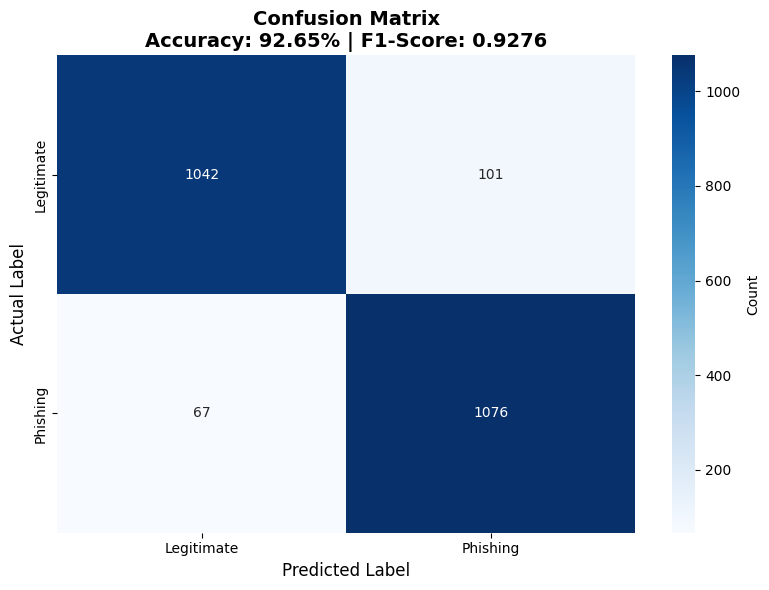

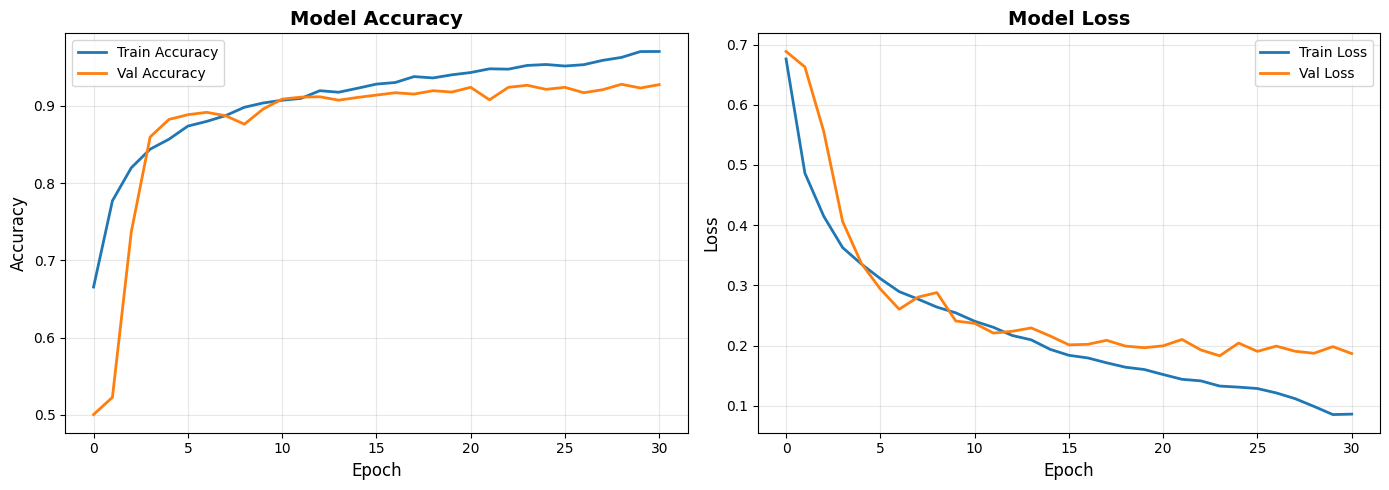


✓ Pipeline completed successfully!


In [14]:

model , preprocessor , history , resutls = main(df)


In [33]:
def Neural_Network_Evaluation(urls , labels):
  urls = preprocessor.transform(urls)
  evaluate_model(model, urls ,labels, plot=True)


# Testing ChatGpt 5000 url

In [22]:
from google.colab import files

uploaded = files.upload()


Saving url_dataset_5000.csv to url_dataset_5000.csv


In [23]:
!ls

'phishing_url_dataset_5000 (1).csv'   sample_data
 phishing_url_dataset_5000.csv	      url_dataset_5000.csv


In [24]:
CG_df = pd.read_csv("url_dataset_5000.csv")

In [25]:
CG_df["label"] = CG_df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-277365720.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CG_df["label"] = CG_df["label"].replace({


In [26]:
CG_df.head()

,url,label
0,https://mcrravlgw.info/login/ileh?redirect=gep...,0
1,https://aghlsktp.app/nargwy/eoadkkhikp,1
2,https://lmpcfqmgc.net/bvlh%25wur%25fz%25sfyh/w...,0
3,https://ncnk.co/login/flhfb?redirect=qjkc,0
4,http://iamzr.io/bdqv/duyq/qyqmeusxpp?page=jQw7...,1



MODEL EVALUATION RESULTS
Accuracy:  0.5060
Precision: 0.5362
Recall:    0.0888
F1-Score:  0.1524

Confusion Matrix:
[[2308  192]
 [2278  222]]

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.50      0.92      0.65      2500
  Legitimate       0.54      0.09      0.15      2500

    accuracy                           0.51      5000
   macro avg       0.52      0.51      0.40      5000
weighted avg       0.52      0.51      0.40      5000



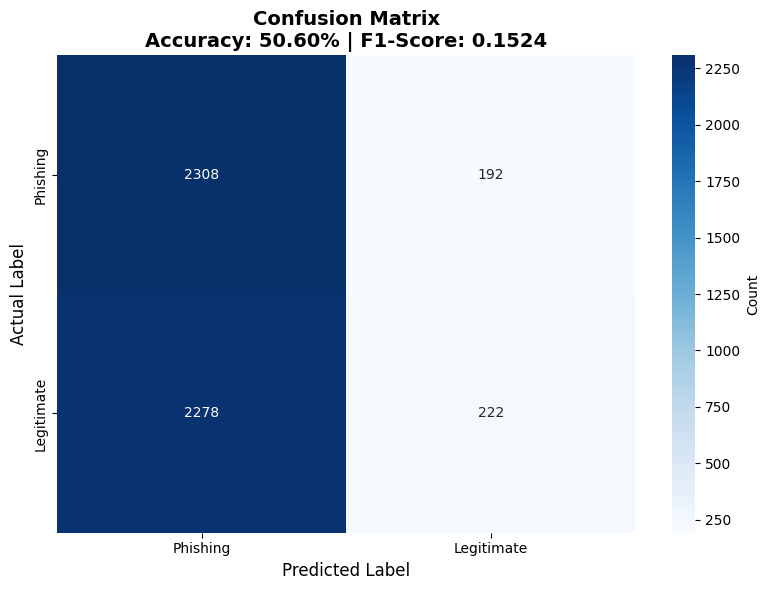

In [34]:
Neural_Network_Evaluation(CG_df.url , CG_df.label)